# Clustering with Gaussian Mixture Models

### Preliminaries

- Goal 
  - Introduction to the Expectation-Maximization (EM) Algorithm with application to Gaussian Mixture Models (GMM)
- Materials        
  - Mandatory
    - These lecture notes
  - Optional
    - Bishop pp. 430-439 for Gaussian Mixture Models
    - Bishop pp. 55-57 for Jensen's inequality
    - Bishop pp. 439-443 for EM applied to GMM
    - Bishop pp. 450-455 for the general EM algorithm


###  Limitations of Simple IID Gaussian Models

Sofar, model inference was solved analytically, but we used strong assumptions:

- IID sampling, $p(D) = \prod_n p(x_n)$

- Simple Gaussian (or multinomial) PDFs, $p(x_n) \sim \mathcal{N}(x_n|\mu,\Sigma)$

- Some limitations of Simple Gaussian Models with IID Sampling
  1. What if the PDF is **multi-modal** (or is just not Gaussian in any other way)?
  2. Covariance matrix $\sigma$ has $D(D+1)/2$ parameters.
    - This quickly becomes **a very large number** for increasing dimension $D$.
  3. Temporal signals are often **not IID**.



###  Towards More Flexible Models

-  What if the PDF is multi-modal (or is just not Gaussian in any other way)?
  -   **Discrete latent** variable models (a.k.a. **mixture** models). We've cover this case in [this lesson](http://nbviewer.ipython.org/github/bertdv/AIP-5SSB0/blob/master/lessons/09_clustering_with_Gaussian_mixture_models/Clustering-with-Gaussian-Mixture-Models.ipynb) .
    
-  Covariance matrix $\Sigma$ has $D(D+1)/2$ parameters. This quickly becomes very large for increasing dimension $D$.
  -  **Continuous latent** variable models (a.k.a. **dimensionality reduction** models). Covered in [lesson 11](http://nbviewer.ipython.org/github/bertdv/AIP-5SSB0/blob/master/lessons/11_continuous_latent_variable_models/Continuous-Latent-Variable-Models-PCA-FA-and-ICA.ipynb).
    
-  Temporal signals are often not IID.
  -  Introduce **Markov dependencies** and **latent state** variable models.
    



### Illustrative Example

- You're now asked to build a density model for a data set ([Old Faithful](https://en.wikipedia.org/wiki/Old_Faithful), Bishop pg. 681) that clearly is not distributed as a single Gaussian:

<img src="./figures/fig-Bishop-A5-Old-Faithfull.png" width="350">

###  Unobserved Classes

Consider again a set of observed data $D=\{x_1,\dotsc,x_N\}$

- This time we suspect that there are unobserved class labels that would help explain (or predict) the data, e.g.,
  - the observed data are the color of living things; the unobserved classes are animals and plants.
  - observed are wheel sizes; unobserved categories are trucks and personal cars.
  - observed is an audio signal; unobserved classes include speech, music, traffic noise, etc.
    
- Classification problems with unobserved classes are called **Clustering** problems. The learning algorithm needs to **discover the classes from the observed data**.


###  Latent Variable Model Specification
 
If the categories were observed as well, these data could be nicely modeled by the previously discussed generative classification framework.

-  Introduce the $1$-of-$K$ variable $z = (z_1,\ldots,z_K)^T$ to represent the unobserved classes. I.o.w. membership of 'unobserved class' $k$ is expressed by $z_k=1$.
  - (NB: our notation is: $Y_k$ for observed targets; $Z_k$ for unobserved targets).
-  Use completely **equivalent model assumptions to linear generative classification**, (except now the class
    labels $z_k$ are not observed),
$$\begin{align*}
p(x_n) &= \sum_{k=1}^K p(z_{k}=1) \, p(x_n|z_{k}=1)  \\
	&= \boxed{\sum_k \pi_k \mathcal{N}\left(x_n|\mu_k,\Sigma_k \right)}
\end{align*}$$
where $p(z_{k}=1)=\pi_k$ are called the mixture coefficients. 

This model is called a **Gaussian Mixture Model**.


###  Gaussian Mixture Models

- GMMs are very popular models. They have decent computational properties and are **universal approximators of densities** (as long as there are enough Gaussians of course)

<img src="./figures/fig-ZoubinG-GMM-universal-approximation.png" width="500">



###  Inference: Log-Likelihood for GMM

- The log-likelihood for observed data $D=\{x_1,\dotsc,x_N\}$,
$$\begin{align*}
\log p(D|\theta) &\stackrel{\text{IID}}{=} \sum_n \log p(x_n|\theta)\\
  &= \sum_n \log \left( \sum_k \pi_k\mathcal{N}(x_n|\mu_k,\Sigma_k) \right)
\end{align*}$$
... and now the log-of-sum cannot be further simplified.

- Compare this to the log-likelihood in [(generative) classification](http://nbviewer.ipython.org/github/bertdv/AIP-5SSB0/blob/master/lessons/07_generative_classification/Generative-Classification.ipynb): $$\sum_k m_k \log \pi_k + \sum_{n,k} y_{nk} \log \mathcal{N}(x_n|\mu_k,\Sigma)$$

- Fortunately GMMs can be trained by maximum likelihood using an efficient algorithm: Expectation-Maximization.


###  Idea: Use the Posterior Responsibility as a Soft Class Indicator

- We don't _observe_ the class labels, but we can compute the expectation for the class labels, given the observation $x_n$:
$$\begin{align*}
\gamma_{nk} &\triangleq \mathrm{E}\left[ z_k|x_n\right] \\
 &= 0\times p(z_{k}=0|x_n) + 1\times p(z_{k}=1|x_n) \\
  &= p(z_{k}=1|x_n) \\
  &= \frac{p(x_n|z_{k}=1)p(z_{k}=1)}{\sum_j p(x_n|z_{j}=1)p(z_{j}=1)} \\
  &= \frac{\pi_k \mathcal{N}(x_n|\mu_k,\Sigma_k)}{\sum_j \pi_j \mathcal{N}(x_n|\mu_j,\Sigma_j)}
\end{align*}$$
            
-  Note that $0 \leq \gamma_{nk} \leq 1$ and is available (i.e., can be evaluated).

-  $\gamma_{nk}$ are soft class indicators, a.k.a. **reponsibilities**.

-  IDEA: Let's apply the (generative) classification formulas and substitute the reponsibilities $\gamma_{nk}$ wherever the formulas use the binary class indicators $y_{nk}$.


###  ML estimation for Clustering

-  Try parameter updates (like [generative Gaussian classification](http://nbviewer.ipython.org/github/bertdv/AIP-5SSB0/blob/master/lessons/07_generative_classification/Generative-Classification.ipynb)):
$$\begin{align*}
\hat \pi_k &= \frac{m_k}{N} \\
\hat \mu_k &= \frac{1}{m_k} \sum_n \gamma_{nk} x_n \\
\hat \Sigma_k  &= \frac{1}{m_k} \sum_{n} \gamma_{nk} (x_n-\hat \mu_k)(x_n-\hat \mu_k)^T
\end{align*}$$
where $m_k = \sum_n \gamma_{nk}$ .

-  But wait ..., the responsibilities $\gamma_{nk}=\frac{\pi_k \mathcal{N}(x_n|\mu_k,\Sigma_k)}{\sum_j \pi_j \mathcal{N}(x_n|\mu_j,\Sigma_j)}$ are a function of the model parameters $\{\pi,\mu,\Sigma\}$ and the parameter updates depend on the responsibilities ...
-  **Solution(?)**: iterate between updating the responsibilities $\gamma_{nk}$ and the model parameters $\{\pi,\mu,\Sigma\}$.

-  This iteration works (!) and is called the **Expectation-Maximization (EM)** algorithm.




#### CODE EXAMPLE

We'll perform clustering on the data set from the illustrative example by fitting a GMM consisting of two Gaussians using the EM algorithm. 

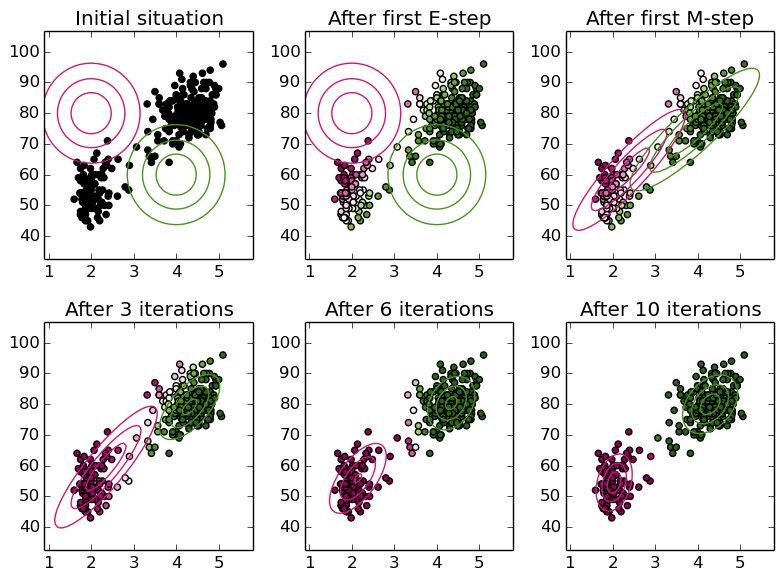

In [1]:
using DataFrames
include("scripts/gmm_plot.jl") # Holds plotting function 
old_faithful = readtable("../files/datasets/old_faithful.csv")
X = convert(Matrix{Float64}, [old_faithful[1] old_faithful[2]]')
N = size(X, 2)

# Initialize the GMM. We assume 2 clusters.
clusters = [MvNormal([4.;60.], diagm([.5;10^2])); 
            MvNormal([2.;80.], diagm([.5;10^2]))]
π_hat = [0.5; 0.5]                    # Mixing weights
γ = fill!(Matrix{Float64}(2,N), NaN)  # Responsibilities (row per cluster)

# Define functions for updating the parameters and responsibilities
function updateResponsibilities!(X, clusters, π_hat, γ)
    # Expectation step: update γ
    norm = [pdf(clusters[1], X) pdf(clusters[2], X)] * π_hat
    γ[1,:] = (π_hat[1] * pdf(clusters[1],X) ./ norm)'
    γ[2,:] = 1 - γ[1,:]
end
function updateParameters!(X, clusters, π_hat, γ)
    # Maximization step: update π_hat and clusters using ML estimation
    m = sum(γ, 2)
    π_hat = m / N
    μ_hat = (X * γ') ./ m'
    for k=1:2
        Σ_k = (((X .- μ_hat[:,k]) .* γ[k,:]) * (X .- μ_hat[:,k])') / m[k]
        clusters[k] = MvNormal(μ_hat[:,k], Σ_k)
    end
end

# Execute the algorithm: iteratively update parameters and responsibilities
subplot(2,3,1); plotGMM(X, clusters, γ); title("Initial situation")
updateResponsibilities!(X, clusters, π_hat, γ)
subplot(2,3,2); plotGMM(X, clusters, γ); title("After first E-step")
updateParameters!(X, clusters, π_hat, γ)
subplot(2,3,3); plotGMM(X, clusters, γ); title("After first M-step")
iter_counter = 1
for i=1:3
    for j=1:i+1
        updateResponsibilities!(X, clusters, π_hat, γ)
        updateParameters!(X, clusters, π_hat, γ)
        iter_counter += 1
    end
    subplot(2,3,3+i); plotGMM(X, clusters, γ); 
    title("After $(iter_counter) iterations")
end
PyPlot.tight_layout()

#### END OF CODE EXAMPLE

### Clustering vs. Classification

<table>
<tr> <td></td><td>**Classification**</td> <td>**Clustering**</td> </tr> 

<tr> <td>1</td><td>Class label $y_n$ is observed</td> <td>Class label $z_n$ is latent</td> </tr>

<tr> <td>2</td><td>log-likelihood **conditions** on observed class<br />$\propto \sum_{nk} y_{nk} \log \mathcal{N}(x_n|\mu_k,\Sigma_k)$</td> <td> log-likelihood **marginalizes** over latent classes<br />$\propto \sum_{n}\log \sum_k \pi_k \mathcal{N}(x_n|\mu_k,\Sigma_k)$</td> </tr>

<tr> <td>3</td><td>'Hard' class selector<br />$y_{nk} = \mathrm{logical}(y_n \in \mathcal{C}_k)$</td> <td>'Soft' class responsibility<br />$\gamma_{nk} = p(z_{k}=1|x_n)$</td> </tr>

<tr> <td>4</td>
<td>Estimation:<BR /> 
$$\begin{align*}
\hat{\pi}_k &= \frac{1}{N}\sum_n y_{nk} \\
\hat{\mu}_k &= \frac{\sum_n y_{nk} x_n}{\sum_n y_{nk}} \\
\hat{\Sigma}_k &= \frac{\sum_n y_{nk} (x_n-\hat\mu_k)(x_n-\hat\mu_k)^T}{\sum_n y_{nk}}
\end{align*}$$
</td> 
<td>Estimation (1 update of M-step!)<BR />
$$\begin{align*}
\hat{\pi}_k &= \frac{1}{N}\sum_n \gamma_{nk} \\
\hat{\mu}_k &= \frac{\sum_n \gamma_{nk} x_n}{\sum_n \gamma_{nk}} \\
\hat{\Sigma}_k &= \frac{\sum_n \gamma_{nk} (x_n-\hat\mu_k)(x_n-\hat\mu_k)^T}{\sum_n \gamma_{nk}}
\end{align*}$$
</td>
</tr>

</table>

-----
_The cell below loads the style file_


In [1]:
open("../../styles/aipstyle.html") do f
    display("text/html", readall(f))
end

<!--
This HTML file contains custom styles and some javascript.
Include it a Jupyter notebook for improved rendering.
-->

<!-- Fonts -->
 
 
 
 
 

<!-- Custom style -->


<!-- MathJax styling -->